In [47]:
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [48]:
df = pd.read_csv("final_dataset.csv")

In [49]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["MM"] = df["datetime"].dt.month

In [50]:
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df = df.set_index('datetime')
df.head()

,HOUR,SEASON,origin,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,AIR_WATER_TMP_DIFF,MM
datetime,,,,,,,,,,,,,,,
2018-09-19 04:40:00,4,1,0,81.0,6.3,8.1,1.68,8.33,6.00,114.0,1013.8,25.9,26.5,0.6,9
2018-09-19 05:40:00,5,1,0,78.0,9.6,12.9,1.70,8.33,5.97,108.0,1014.4,25.0,26.4,1.4,9
2018-09-19 06:40:00,6,1,0,109.0,6.5,9.6,1.80,7.14,6.21,101.0,1015.2,23.3,26.4,3.1,9
2018-09-19 07:40:00,7,1,0,83.0,4.5,9.7,1.74,8.33,6.23,91.0,1015.5,25.1,26.4,1.3,9
2018-09-19 08:40:00,8,1,0,83.0,4.7,6.0,1.84,7.14,6.06,89.0,1015.9,25.2,26.4,1.2,9


## origin: 0 -> station 1, origin: 1 -> station 2, origin: 2 -> filled with median

In [51]:
# df = df[df["origin"] == 0]
df.drop(columns = ["origin"], axis = 1, inplace=True)

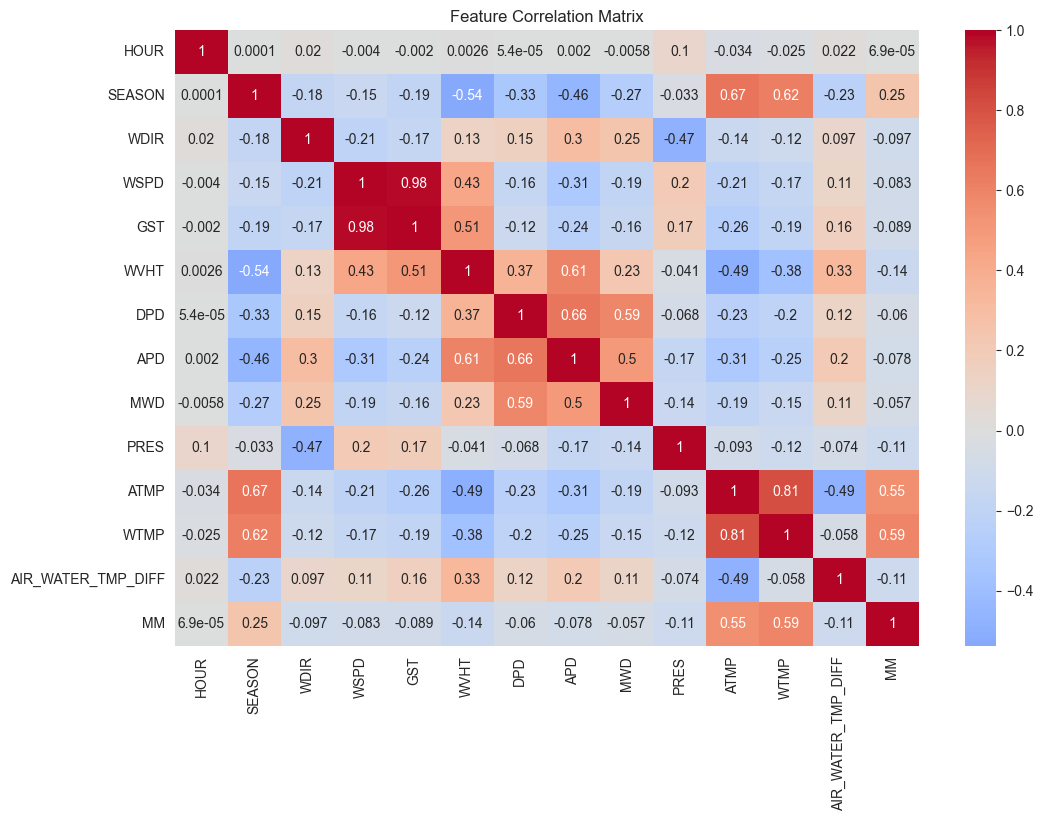

WVHT                  1.000000
APD                   0.605980
GST                   0.507238
WSPD                  0.434621
DPD                   0.366727
AIR_WATER_TMP_DIFF    0.329893
MWD                   0.230280
WDIR                  0.133241
HOUR                  0.002595
PRES                 -0.041340
MM                   -0.139780
WTMP                 -0.376368
ATMP                 -0.494768
SEASON               -0.538475
Name: WVHT, dtype: float64


In [52]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

print(corr['WVHT'].sort_values(ascending=False))

In [53]:
from sklearn.feature_selection import mutual_info_regression

X = df.drop(columns=['WVHT'], axis = 1)
y = df['WVHT']

X = X.fillna(0)

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

APD                   0.347355
MM                    0.287884
GST                   0.275796
WSPD                  0.251311
SEASON                0.200322
ATMP                  0.188751
WTMP                  0.165883
MWD                   0.142788
DPD                   0.122303
PRES                  0.105896
AIR_WATER_TMP_DIFF    0.092372
WDIR                  0.069737
HOUR                  0.000000
dtype: float64


In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

APD                   0.326839
SEASON                0.290118
GST                   0.235367
WSPD                  0.023590
PRES                  0.020482
ATMP                  0.016783
WDIR                  0.015081
WTMP                  0.014788
MWD                   0.014337
AIR_WATER_TMP_DIFF    0.013634
MM                    0.011022
DPD                   0.010667
HOUR                  0.007293
dtype: float64


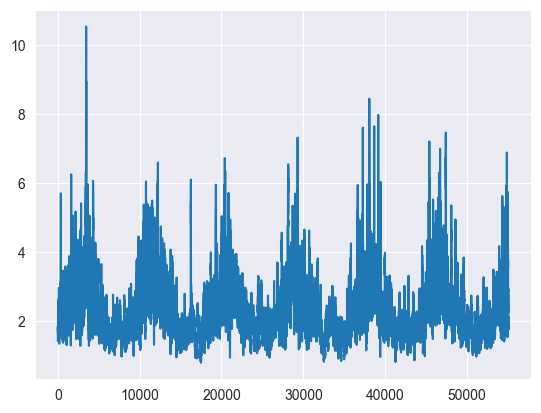

In [55]:
plt.plot(range(len(df["WVHT"])), df["WVHT"])
plt.show()

In [56]:
features = ['SEASON', 'WDIR', 'WSPD','GST','DPD','APD','MWD','PRES','ATMP','WTMP','AIR_WATER_TMP_DIFF', 'MM']
target = 'WVHT'

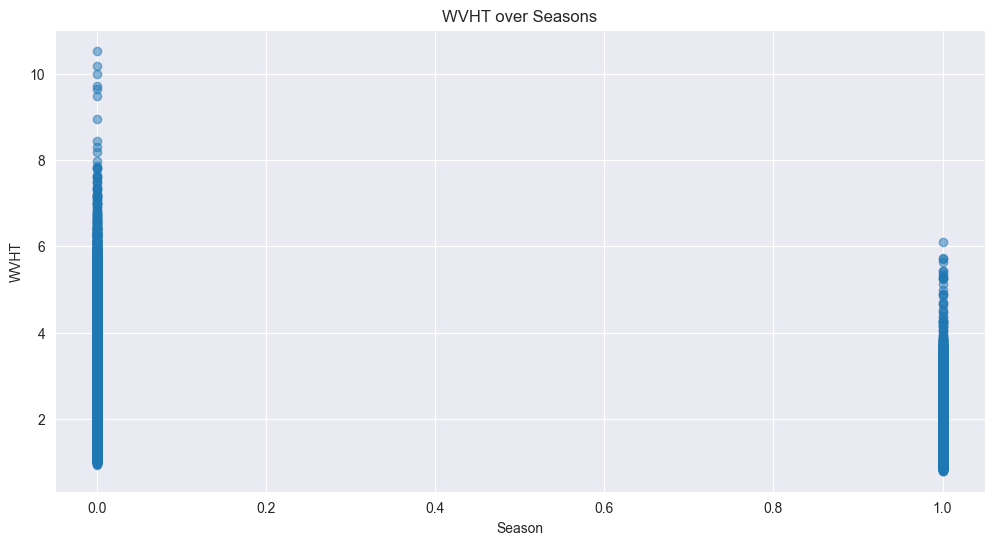

In [57]:
plt.figure(figsize=(12,6))
plt.scatter(df["SEASON"], df["WVHT"], alpha=0.5)
plt.xlabel("Season")
plt.ylabel("WVHT")
plt.title("WVHT over Seasons")
plt.show()

In [58]:
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [59]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

In [60]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, shuffle=False)

In [61]:
sequence_length = 24
batch_size = 32

train_dataset = timeseries_dataset_from_array(
    data=X_train_final,
    targets=y_train_final,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

val_dataset = timeseries_dataset_from_array(
    data=X_val,
    targets=y_val,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

test_dataset = timeseries_dataset_from_array(
    data=X_test_scaled,
    targets=y_test_scaled,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

In [62]:
num_train_sequences = sum(1 for _ in train_dataset)
num_val_sequences = sum(1 for _ in val_dataset)
print(num_train_sequences, num_val_sequences)

1102 275


In [63]:
model = Sequential([
    Input(shape=(sequence_length, len(features))),
    LSTM(50, activation='tanh', input_shape=(sequence_length, len(features))),
    Dense(1) 
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/Users/arthursliwinski/PycharmProjects/Data-Mining---Wave-Height-Prediction/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,651 (49.42 KB)

 Trainable params: 12,651 (49.42 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=50
# )

In [65]:
from tensorflow.keras.models import load_model

model.load_weights('models/lstm_wave_model.h5')

In [66]:
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.title('Training vs Validation Loss')
# plt.legend()
# plt.show()

In [67]:
y_pred_scaled = model.predict(test_dataset)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled[sequence_length-1:])  # first few can't be predicted

# Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.700, MAE: 0.452, R2: 0.378


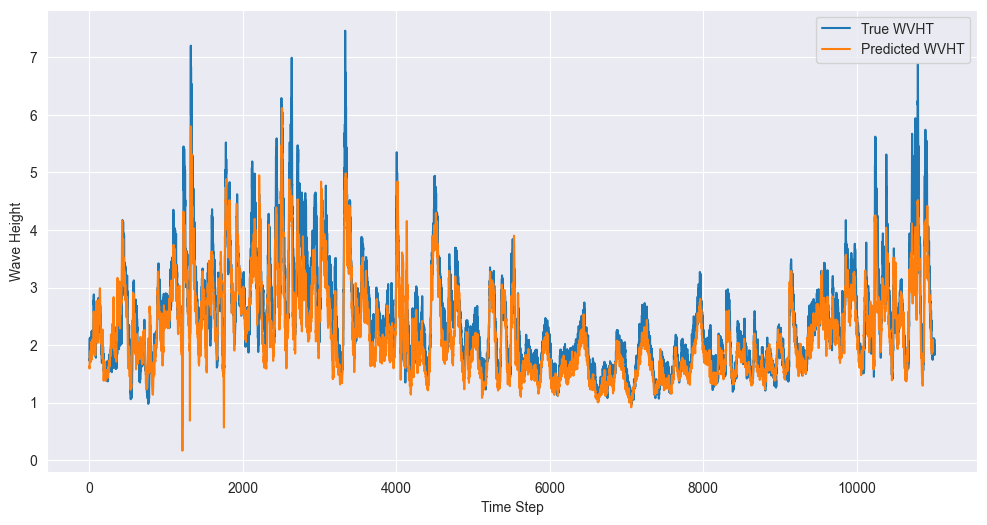

In [68]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True WVHT')
plt.plot(y_pred, label='Predicted WVHT')
plt.xlabel('Time Step')
plt.ylabel('Wave Height')
plt.legend()
plt.show()

In [69]:
min_len = min(len(y_pred.flatten()), len(y_test.flatten()))
y_pred_aligned = y_pred.flatten()[:min_len]
y_true_aligned = y_test.flatten()[:min_len]


timestamps = df.index[-min_len:]


df_eval = df.loc[timestamps].copy()
df_eval = df_eval.assign(
    y_true=y_true_aligned,
    y_pred=y_pred_aligned
)
df_eval["residual"] = df_eval["y_true"] - df_eval["y_pred"]
df_eval["squared_error"] = df_eval["residual"] ** 2
df_eval["month"] = df_eval.index.month
df_eval["week"] = df_eval.index.isocalendar().week.astype(int)
df_eval.head()

,HOUR,SEASON,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,AIR_WATER_TMP_DIFF,MM,y_true,y_pred,residual,squared_error,month,week
datetime,,,,,,,,,,,,,,,,,,,,
2023-09-30 19:40:00,19,1,91.0,7.8,9.5,1.85,8.33,5.89,102.0,1019.7,26.7,26.8,0.1,9,1.76,1.634133,0.125867,0.015843,9,39
2023-09-30 20:40:00,20,1,100.0,7.3,8.9,1.77,9.09,5.59,109.0,1020.0,26.8,26.9,0.1,9,1.73,1.634137,0.095863,0.009190,9,39
2023-09-30 21:40:00,21,1,92.0,6.7,8.1,1.77,8.33,5.95,93.0,1019.6,26.6,26.9,0.3,9,1.82,1.596711,0.223289,0.049858,9,39
2023-09-30 22:40:00,22,1,85.0,7.1,8.6,1.89,8.33,6.14,93.0,1018.7,26.6,26.9,0.3,9,1.93,1.593180,0.336820,0.113447,9,39
2023-09-30 23:40:00,23,1,93.0,8.5,12.4,1.87,8.33,5.81,103.0,1018.2,26.6,26.9,0.3,9,1.90,1.682767,0.217233,0.047190,9,39


In [70]:
# def discretize(df, cols, q=4):
#     for c in cols:
#         df[f"{c}_bin"] = pd.qcut(df[c], q=q, duplicates='drop')
#     return df

def discretize(df, cols, q=4):
    for c in cols:
        df[f"{c}_bin"] = pd.qcut(df[c], q=q, duplicates='drop')
        # optional: create a readable label
        df[f"{c}_bin_label"] = df[f"{c}_bin"].apply(
            lambda x: f"{x.left:.2f}–{x.right:.2f}" if pd.notna(x) else "NA"
        )
    return df

cont_features = ["WSPD", "WVHT", "DPD", "ATMP", "WTMP", "AIR_WATER_TMP_DIFF", "SEASON"]
df_eval = discretize(df_eval, cont_features, q=5)
df_eval.head()

,HOUR,SEASON,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,...,DPD_bin,DPD_bin_label,ATMP_bin,ATMP_bin_label,WTMP_bin,WTMP_bin_label,AIR_WATER_TMP_DIFF_bin,AIR_WATER_TMP_DIFF_bin_label,SEASON_bin,SEASON_bin_label
datetime,,,,,,,,,,,,,,,,,,,,,
2023-09-30 19:40:00,19,1,91.0,7.8,9.5,1.85,8.33,5.89,102.0,1019.7,...,"(4.999, 8.33]",5.00–8.33,"(26.2, 27.3]",26.20–27.30,"(26.2, 27.0]",26.20–27.00,"(-0.001, 0.4]",-0.00–0.40,"(-0.001, 1.0]",-0.00–1.00
2023-09-30 20:40:00,20,1,100.0,7.3,8.9,1.77,9.09,5.59,109.0,1020.0,...,"(8.33, 10.0]",8.33–10.00,"(26.2, 27.3]",26.20–27.30,"(26.2, 27.0]",26.20–27.00,"(-0.001, 0.4]",-0.00–0.40,"(-0.001, 1.0]",-0.00–1.00
2023-09-30 21:40:00,21,1,92.0,6.7,8.1,1.77,8.33,5.95,93.0,1019.6,...,"(4.999, 8.33]",5.00–8.33,"(26.2, 27.3]",26.20–27.30,"(26.2, 27.0]",26.20–27.00,"(-0.001, 0.4]",-0.00–0.40,"(-0.001, 1.0]",-0.00–1.00
2023-09-30 22:40:00,22,1,85.0,7.1,8.6,1.89,8.33,6.14,93.0,1018.7,...,"(4.999, 8.33]",5.00–8.33,"(26.2, 27.3]",26.20–27.30,"(26.2, 27.0]",26.20–27.00,"(-0.001, 0.4]",-0.00–0.40,"(-0.001, 1.0]",-0.00–1.00
2023-09-30 23:40:00,23,1,93.0,8.5,12.4,1.87,8.33,5.81,103.0,1018.2,...,"(4.999, 8.33]",5.00–8.33,"(26.2, 27.3]",26.20–27.30,"(26.2, 27.0]",26.20–27.00,"(-0.001, 0.4]",-0.00–0.40,"(-0.001, 1.0]",-0.00–1.00


In [71]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def time_aware_Q(subset, global_rmse, lambda_t=0.25):
    # rmse_t = subset.groupby("month").apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))
    rmse_t = subset.groupby("month")[["y_true", "y_pred"]].apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))
    if len(rmse_t) < 3:
        return None
    mean_rmse = rmse_t.mean()
    var_rmse = rmse_t.var()
    Q = (mean_rmse - global_rmse) - lambda_t * var_rmse
    return Q, mean_rmse, var_rmse

In [72]:
def scape_temporal(df, feature_cols, min_support=100, lambda_t=0.25, top_k=10):
    global_rmse = compute_rmse(df["y_true"], df["y_pred"])
    results = []
    for col in tqdm(feature_cols):
        for val in df[col].unique():
            subset = df[df[col] == val]
            if len(subset) < min_support:
                continue
            out = time_aware_Q(subset, global_rmse, lambda_t)
            if out is None:
                continue
            Q, mean_rmse, var_rmse = out
            results.append({
                "rule": [(col, val)],
                "Q": Q,
                "mean_rmse": mean_rmse,
                "var_rmse": var_rmse,
                "support": len(subset)
            })

    results = sorted(results, key=lambda x: x["Q"], reverse=True)[:top_k]
    return results, global_rmse

binned_features = [f"{c}_bin" for c in cont_features]
results, global_rmse = scape_temporal(df_eval, binned_features, min_support=100, lambda_t=0.25, top_k=10)

print(f"Global RMSE = {global_rmse:.4f}\nTop exceptional subgroups:")


for r in results:
    rule = r["rule"][0]
    feature, interval = rule
    if isinstance(interval, pd.Interval):
        left = round(interval.left, 2)
        right = round(interval.right, 2)
        print(f"{feature} ∈ [{left}, {right}] | Q={r['Q']:.3f}, n={r['support']}, mean_RMSE={r['mean_rmse']:.3f}")
    else:
        print(f"{feature} = {interval} | Q={r['Q']:.3f}, n={r['support']}, mean_RMSE={r['mean_rmse']:.3f}")

100%|██████████| 7/7 [00:00<00:00, 170.34it/s]

Global RMSE = 0.4315
Top exceptional subgroups:
WTMP_bin ∈ [22.5, 23.5] | Q=0.154, n=2221, mean_RMSE=0.601
WVHT_bin ∈ [3.03, 7.46] | Q=0.075, n=2189, mean_RMSE=0.514
DPD_bin ∈ [11.43, 13.79] | Q=-0.007, n=2795, mean_RMSE=0.438
WSPD_bin ∈ [-0.0, 4.5] | Q=-0.007, n=2299, mean_RMSE=0.437
WSPD_bin ∈ [4.5, 6.2] | Q=-0.013, n=2206, mean_RMSE=0.431
WTMP_bin ∈ [23.5, 25.4] | Q=-0.014, n=2325, mean_RMSE=0.427
AIR_WATER_TMP_DIFF_bin ∈ [1.0, 1.5] | Q=-0.041, n=1964, mean_RMSE=0.400
WVHT_bin ∈ [2.44, 3.03] | Q=-0.044, n=2194, mean_RMSE=0.397
SEASON_bin ∈ [-0.0, 1.0] | Q=-0.045, n=10997, mean_RMSE=0.395
AIR_WATER_TMP_DIFF_bin ∈ [1.5, 7.1] | Q=-0.045, n=1998, mean_RMSE=0.395


/var/folders/pw/sqtqq99j5njg0lw4yrl1jcmw0000gn/T/ipykernel_81667/2907674244.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_month = subset.groupby("month").apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))


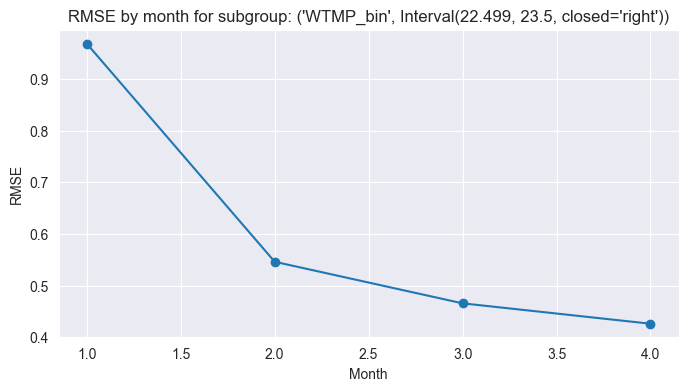

In [73]:
def plot_rmse_trend(df, rule):
    subset = df[df[rule[0][0]] == rule[0][1]]
    rmse_month = subset.groupby("month").apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))
    plt.figure(figsize=(8,4))
    plt.plot(rmse_month.index, rmse_month.values, marker='o')
    plt.title(f"RMSE by month for subgroup: {rule[0]}")
    plt.xlabel("Month")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

plot_rmse_trend(df_eval, results[0]["rule"])

In [74]:
import itertools

def get_permutations(df, feature_cols):
    """ 
    This function takes a dataframe and a list of required column names.
    It then determines stores all possible value pairs of all combinations of 2 columns. 
    Important to note: Given column A, and column B, if (A,B) in the list of permutations, 
    the function will not add (B, A), or vice versa. 
    
    
    """
    # All permutations stores a dictionary, where each key consists of the two column names represented by a tuple
    # and each of the values comprises a list of permutations of values, given the two columns in the key

    all_permutations = {}

    for col_1 in feature_cols:
        for col_2 in feature_cols:
            if col_1 == col_2:
                continue 
            if (col_1, col_2) in all_permutations or (col_2, col_1) in all_permutations:
                continue
            col_1_val = df[col_1].unique().tolist()
            col_2_val = df[col_2].unique().tolist()

            # permutations stores the permutations of the current two columns
            permutations = []

            for r in itertools.product(col_1_val, col_2_val):
                permutation = (r[0], r[1])
                permutations.append(permutation)

            all_permutations[(col_1, col_2)] = permutations   
    return all_permutations


In [75]:

def scape_temporal_2(df, feature_cols, min_support=100, lambda_t=0.25, top_k=10):
    """ 
    This function fucntions very similar to scale_temporal, the main difference is found in the subgroup predicate. 
    Instead of the predicate involving one column, space_temporal_2 utilises an "AND" in order to capture more complex subgroups,
    based on two descriptors, instead of one. 
    """


    
    global_rmse = compute_rmse(df["y_true"], df["y_pred"])
    results = []
    permutations = get_permutations(df, feature_cols)

    for key in permutations:
        col_1 = key[0]
        col_2 = key[1]

        for val1, val2 in permutations[key]:
            # The predicate now contains two columns and two values
            subset = df[(df[col_1] == val1) & (df[col_2] == val2)]
            if len(subset) < min_support:
                continue
            out = time_aware_Q(subset, global_rmse, lambda_t)
            if out is None:
                continue
            Q, mean_rmse, var_rmse = out
            results.append({
                "rule": [(col_1, val1), (col_2, val2)],
                "Q": Q,
                "mean_rmse": mean_rmse,
                "var_rmse": var_rmse,
                "support": len(subset)
            })


    results = sorted(results, key=lambda x: abs(x["Q"]), reverse=True)[:top_k]
    return results, global_rmse
            
        

binned_features = [f"{c}_bin" for c in cont_features]

### For inclusion/exclusion of WVHT, comment or uncomment the following line
binned_features.remove("WVHT_bin")
### -------

results, global_rmse = scape_temporal_2(df_eval, binned_features, min_support=100, lambda_t=0.25, top_k=10)


print(f"Global RMSE = {global_rmse:.4f}\nTop exceptional subgroups:")


for r in results:
    rule_1 = r["rule"][0]
    feature_1, interval_1 = rule_1
    rule_2 = r["rule"][1]
    feature_2, interval_2 = rule_2
    if isinstance(interval_1, pd.Interval) and isinstance(interval_2, pd.Interval) :
        left_1 = round(interval_1.left, 2)
        right_1 = round(interval_1.right, 2)
        left_2 = round(interval_2.left, 2)
        right_2 = round(interval_2.right, 2)
        print(f"{feature_1} ∈ [{left_1}, {right_1}], {feature_2} ∈ [{left_2}, {right_2}] | Q={r['Q']:.3f}, n={r['support']}, mean_RMSE={r['mean_rmse']:.3f}")
    else:
        print(f"{feature_1} = {interval_1}, {feature_2} = {interval_2} | Q={r['Q']:.3f}, n={r['support']}, mean_RMSE={r['mean_rmse']:.3f}")




Global RMSE = 0.4315
Top exceptional subgroups:
ATMP_bin ∈ [26.2, 27.3], AIR_WATER_TMP_DIFF_bin ∈ [1.0, 1.5] | Q=-0.269, n=146, mean_RMSE=0.162
WSPD_bin ∈ [4.5, 6.2], WTMP_bin ∈ [22.5, 23.5] | Q=0.259, n=300, mean_RMSE=0.717
WTMP_bin ∈ [22.5, 23.5], AIR_WATER_TMP_DIFF_bin ∈ [1.5, 7.1] | Q=0.251, n=416, mean_RMSE=0.749
DPD_bin ∈ [11.43, 13.79], WTMP_bin ∈ [22.5, 23.5] | Q=0.249, n=650, mean_RMSE=0.705
WSPD_bin ∈ [-0.0, 4.5], WTMP_bin ∈ [22.5, 23.5] | Q=0.232, n=221, mean_RMSE=0.693
DPD_bin ∈ [5.0, 8.33], WTMP_bin ∈ [25.4, 26.2] | Q=-0.221, n=442, mean_RMSE=0.215
WSPD_bin ∈ [6.2, 7.4], ATMP_bin ∈ [26.2, 27.3] | Q=-0.215, n=533, mean_RMSE=0.218
DPD_bin ∈ [5.0, 8.33], ATMP_bin ∈ [26.2, 27.3] | Q=-0.210, n=797, mean_RMSE=0.223
DPD_bin ∈ [5.0, 8.33], ATMP_bin ∈ [25.2, 26.2] | Q=-0.207, n=696, mean_RMSE=0.225
ATMP_bin ∈ [25.2, 26.2], WTMP_bin ∈ [25.4, 26.2] | Q=-0.204, n=692, mean_RMSE=0.236
